# Setting watershed boundary conditions on a raster grid

- This tutorial ilustrates how to set watershed boundary conditions on a raster grid.
- Note that a watershed is assumed to have a ring of nodes around the core nodes that are closed boundaries (i.e. no flux can cross these nodes, or more correctly, no flux can cross the faces around the nodes).
- This means that automatically the nodes on the outer perimeter of the grid will be set to be closed boundary.
- By definitation a watershed also has one outlet through which fluxes can pass.  Here the outlet is set as the node that has the lowest value, is not a nodata_value node, and is adjacent to at least one closed boundary node.  
- This means that an outlet can be on the outer perimeter of the raster.  However, the outlet does not need to be on the outer perimeter of the raster.

## The first example uses set_watershed_boundary_condition, which finds the outlet for the user.
- First import what we need.

In [1]:
from landlab import RasterModelGrid

- Now we create a 5 by 5 grid with a spacing (dx and dy) of 1.
- We also create an elevation field with value of 1. everywhere, except at the outlet, where the elevation is 0.  In this case the outlet is in the middle of the bottom row, at location (0,2), and has a node id of 2.

In [2]:
mg1 = RasterModelGrid((5, 5), 1.0)
z1 = mg1.add_ones("topographic__elevation", at="node").reshape(mg1.shape)
z1[0, 2] = 0.0
z1

array([[1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

- The set_watershed_boundary_condition in RasterModelGrid will find the outlet of the watershed.
- This method takes the node data, in this case z, and, optionally the no_data value.
- This method sets all nodes that have no_data values to closed boundaries.
- This example does not have any no_data values, which is fine.  
- In this case, the code will set all of the perimeter nodes as BC_NODE_IS_CLOSED(boundary status 4) in order to create this boundary around the core nodes. 
- The exception on the perimeter is node 2 (with elevation of 0).  Although it is on the perimeter, it has a value and it has the lowest value.  So in this case node 2 will be set as BC_NODE_IS_FIXED_VALUE (boundary status 1).
- The rest of the nodes are set as a CORE_NODE (boundary status 0)

In [3]:
mg1.set_watershed_boundary_condition(mg1.at_node["topographic__elevation"])

- Check to see that node status were set correctly.
- `imshow` will default to not plot the value of BC_NODE_IS_CLOSED nodes, which is why we override this below with the option color_for_closed

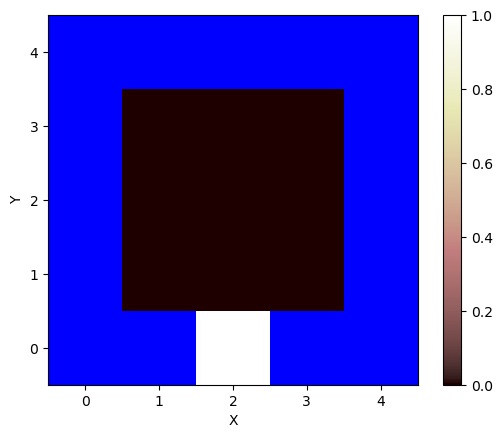

In [4]:
mg1.imshow(mg1.status_at_node, color_for_closed="blue")

## The second example uses set_watershed_boundary_condition_outlet_coords 
- In this case the user knows the coordinates of the outlet node.
- First instantiate a new grid, with new data values.

In [5]:
mg2 = RasterModelGrid((5, 5), 10.0)
z2 = mg2.add_ones("topographic__elevation", at="node").reshape(mg2.shape)
z2[0, 1] = 0.0
z2

array([[1., 0., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

- Note that the node with zero elevation, which will be the outlet, is now at location (0,1).
- Note that even though this grid has a dx & dy of 10., the outlet coords are still (0,1).
- Set the boundary conditions.

In [6]:
mg2.set_watershed_boundary_condition_outlet_coords(
    (0, 1), mg2.at_node["topographic__elevation"]
)

- Plot grid of boundary status information

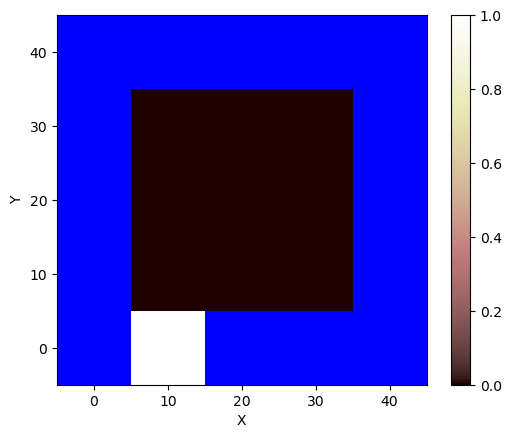

In [7]:
mg2.imshow(mg2.status_at_node, color_for_closed="blue")

## The third example uses set_watershed_boundary_condition_outlet_id 
- In this case the user knows the node id value of the outlet node.
- First instantiate a new grid, with new data values.

In [8]:
mg3 = RasterModelGrid((5, 5), 5.0)
z3 = mg3.add_ones("topographic__elevation", at="node").reshape(mg3.shape)
z3[1, 0] = 0.0
z3

array([[1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

- Set boundary conditions with the outlet id.
- Note that here we know the id of the node that has a value of zero and choose this as the outlet.  But the code will not complain if you give it an id value of a node that does not have the smallest data value.

In [13]:
mg3.set_watershed_boundary_condition_outlet_id(10, mg3.at_node["topographic__elevation"], -9999.0)

- Another plot to illustrate the results.

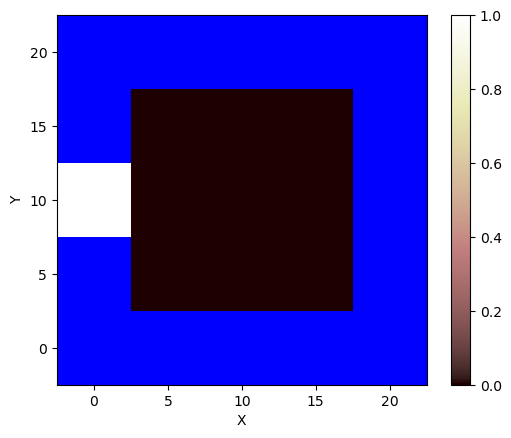

In [14]:
mg3.imshow(mg3.status_at_node, color_for_closed="blue")

## The final example uses set_watershed_boundary_condition on a watershed that was exported from Arc.

- First import ``esri_ascii.lazy_load`` and then import the DEM data.
- The ``add_halo`` function add a ring of no-data values around the data.
- This is done just in case there are data values on the edge of the raster.  These would have to become closed to set watershed boundary conditions, but in order to avoid that, we add a perimeter to the data.

In [16]:
from landlab.io import esri_ascii
from landlab.utils.add_halo import add_halo

with open("west_bijou_gully.asc") as fp:
    info, data = esri_ascii.lazy_load(fp, name="topographic__elevation", at="node")

data_with_halo = add_halo(data.reshape(info.shape), halo=1, halo_value=0)

grid_bijou = RasterModelGrid(data_with_halo.shape, xy_spacing=info.xy_spacing)
grid_bijou.at_node["topographic__elevation"] = data_with_halo

- Let's plot the data to see what the topography looks like.

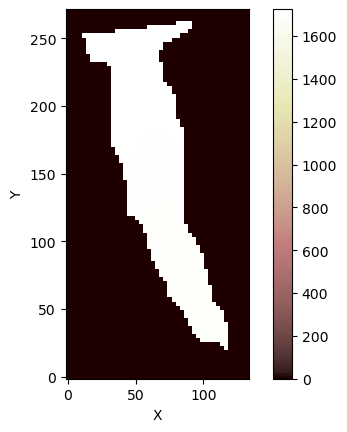

In [17]:
grid_bijou.imshow(grid_bijou.at_node["topographic__elevation"])

- In this case the nodata value is zero.  This skews the colorbar, but we can at least see the shape of the watershed.
- Let's set the boundary condition.  Remember we don't know the outlet id.

In [18]:
grid_bijou.set_watershed_boundary_condition(
    grid_bijou.at_node["topographic__elevation"], 0
)

- Now we can look at the boundary status of the nodes to see where the found outlet was.

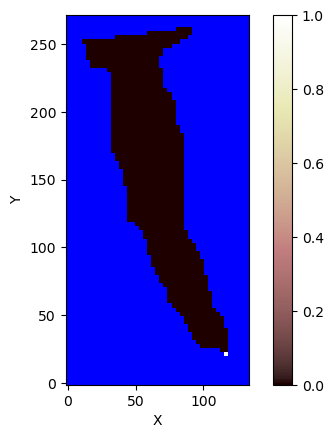

In [19]:
grid_bijou.imshow(grid_bijou.status_at_node, color_for_closed="blue")

- This looks sensible.
- Now that the boundary conditions ae set, we can also look at the topography. 
- `imshow` will default to show boundaries as black, as illustrated below.  But that can be overwridden as we have been doing all along.

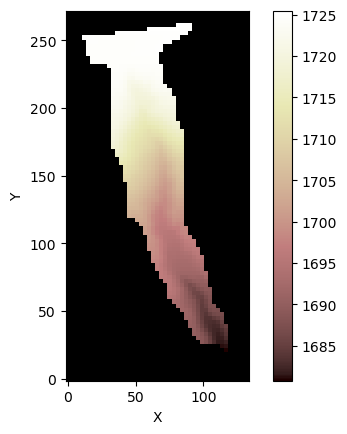

In [20]:
grid_bijou.imshow(grid_bijou.at_node["topographic__elevation"])